# Privacy Preserving Linear Regression on `load_boston` Data using TensorFlow API

In [1]:
# ML
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from sklearn.datasets import load_boston

# crypto
from phe import paillier

## Part 1 - Train the model using plaintext

In [2]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features, labels):
    n_training_samples, n_dim = features.shape
    # concatenate a column of 1's (the bias factor) to the feature set
    f = np.reshape(np.c_[np.ones(n_training_samples), features], [n_training_samples, n_dim + 1])
    l = np.reshape(labels, [n_training_samples, 1])
    return f, l

In [3]:
# 1 - load the dataset
features, labels = load_boston(True)

# 2 - normalize the features
normalized_features = feature_normalize(features)

# 3 - append the bias column and reshape the data
f, l = append_bias_reshape(normalized_features, labels)
n_dim = f.shape[1]

# 4 - randomly partition the data into training and testing sets with 20% of data for testing
rnd_indices = np.random.rand(len(f)) < 0.8

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]

In [4]:
# 5 - set model parameters
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float)

X = tf.placeholder(tf.float32, [None, n_dim])
Y = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.ones([n_dim, 1]))

init = tf.global_variables_initializer()

In [5]:
# 6 - construct the TF dataflow graph
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [6]:
# 7 - train the model
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={
        X: train_x,
        Y: train_y
    })
    cost_history = np.append(cost_history, sess.run(cost, feed_dict={
        X: train_x,
        Y: train_y
    }))

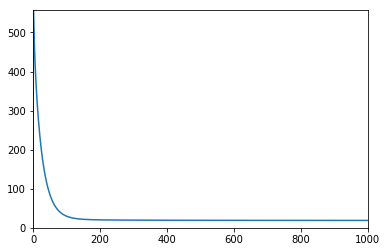

In [7]:
# 8 - plot cost history as training was performed
plt.plot(range(len(cost_history)), cost_history)
plt.axis([0, training_epochs, 0, np.max(cost_history)])
plt.show()

Mean square error: 35.06235297048453


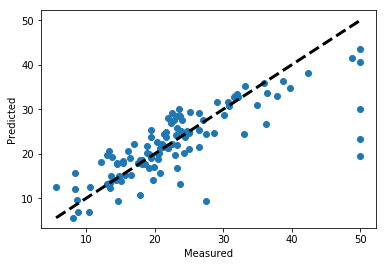

In [8]:
# 9 - test the model on testing data
pred_y = sess.run(y_, feed_dict = {
    X: test_x
})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print('Mean square error: {}'.format(sess.run(mse)))

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Part 2 - Perform Prediction on Encrypted Data

In [36]:
# Generate Paillier keypair
pubkey, privkey = paillier.generate_paillier_keypair(n_length=512)

In [37]:
import copy
from decimal import Decimal

# Pick a feature row and modify it slightly to simulate an incoming, new data
newFeatures = copy.deepcopy(f[10])
standardNormalRandom = [x/10 for x in np.random.randn(14, 1)]
for i in range(len(newFeatures)):
    newFeatures[i] += standardNormalRandom[i]

In [47]:
# Encrypt the data
enc_newFeatures = np.array([Decimal(pubkey.encrypt(x).ciphertext()) for x in newFeatures])
enc_newFeatures = np.reshape(enc_newFeatures, (1, len(newFeatures)))

In [52]:
# Performm prediction over the trained model
pred_enc = sess.run(y_, feed_dict = {
    X: enc_newFeatures
})
print(pred_enc)

[[nan]]


In [51]:
# Decrypt the output to see the prediciton result

prediction = privkey.decrypt(pred_enc)
print('prediction:', prediction)

TypeError: Expected encrypted_number to be an EncryptedNumber not: <class 'numpy.ndarray'>

In [49]:
enc_newFeatures.shape

(1, 14)

In [40]:
enc_newFeatures

[Decimal('70732883696323297383500971337535336809157834097716877678932716225977237808948277759110463940674995048412069976642488996291339972504896432991101655169979986183355253525562738460076428371079002942915846835338089749802346013331976600729616883861947286737374870489141656672173322451376877831719658521506653993485'),
 Decimal('83938841860085896753134746730523536746351670867291204212243215873463840169567052519670184347510670512483089511896655025561937915511477809295595736653896766827233078441858611082768946566074179654698329210724682085572053215425056438992796231208563905759810823201775704885955172737234137687410731653571208842264'),
 Decimal('5868416202389812376960550121700137655679728959392432737025393578024911906387796281569602955178857506843511462735169211155685844882824450410458850565763571610627543854731067571823007143923382652504552829571440296527052831309676547284586681623089931947885603979123696433060736270383437802553585508685227107941'),
 Decimal('3638369989860776557014168

In [ ]:
sess.close()